### Beauty

In [1]:
import ast
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from tqdm import tqdm

In [2]:
dataset_name = "Beauty"
dataset_dir = "/data/common/RecommendationDatasets/{dataset_name}_Amazon14/topics/".format(dataset_name=dataset_name)

topics = [
    "color", 
    "compatibility", 
    "efficacy", 
    "ingredients", 
    "longevity", 
    "packaging", 
    "price", 
    "scent", 
    "service", 
    "texture"
]

sentiments = [
    "positive",
    "negative",
    "neutral"
]

topics.sort()
print(topics)
with open(os.path.join(dataset_dir, "topics.json"), "w") as f:
    json.dump(topics, f)

['color', 'compatibility', 'efficacy', 'ingredients', 'longevity', 'packaging', 'price', 'scent', 'service', 'texture']


In [3]:
data_df = pd.read_csv(os.path.join(dataset_dir, "statement.csv"))
data_df.head()

,helpful,reviewTime,rating,timestamp,review,user_name,user_id,item_id,review_title,statements
0,"[3, 4]","01 30, 2014",1.0,1391040000,Very oily and creamy. Not at all what I expect...,Andrea,A1YJEY40YUW4SE,7806397051,Don't waste your money,"[{'statement': 'has oily texture', 'topic': 't..."
1,"[1, 1]","04 18, 2014",3.0,1397779200,This palette was a decent price and I was look...,Jessica H.,A60XNB876KYML,7806397051,OK Palette!,"[{'statement': 'has a decent price', 'topic': ..."
2,"[0, 1]","09 6, 2013",4.0,1378425600,The texture of this concealer pallet is fantas...,Karen,A3G6XNM240RMWA,7806397051,great quality,"[{'statement': 'has fantastic texture', 'topic..."
3,"[2, 2]","12 8, 2013",2.0,1386460800,I really can't tell what exactly this thing is...,Norah,A1PQFP6SAJ6D80,7806397051,Do not work on my face,"[{'statement': 'has a non-powder texture', 'to..."
4,"[0, 0]","10 19, 2013",3.0,1382140800,"It was a little smaller than I expected, but t...",Nova Amor,A38FVHZTNQ271F,7806397051,It's okay.,"[{'statement': 'is smaller than expected', 'to..."


In [4]:
statement_triplets = data_df["statements"].tolist()
print(statement_triplets[0:5])

["[{'statement': 'has oily texture', 'topic': 'texture', 'sentiment': 'negative'}, {'statement': 'has creamy texture', 'topic': 'texture', 'sentiment': 'negative'}, {'statement': 'performs poorly for highlighting', 'topic': 'efficacy', 'sentiment': 'negative'}, {'statement': 'performs poorly for contouring', 'topic': 'efficacy', 'sentiment': 'negative'}, {'statement': 'was delivered later than expected', 'topic': 'service', 'sentiment': 'negative'}]", "[{'statement': 'has a decent price', 'topic': 'price', 'sentiment': 'positive'}, {'statement': 'offers multiple shades', 'topic': 'color', 'sentiment': 'positive'}, {'statement': 'provides decent coverage', 'topic': 'color', 'sentiment': 'positive'}, {'statement': 'tends to cake on application', 'topic': 'texture', 'sentiment': 'negative'}, {'statement': 'tends to crease during wear', 'topic': 'longevity', 'sentiment': 'negative'}]", "[{'statement': 'has fantastic texture', 'topic': 'texture', 'sentiment': 'positive'}, {'statement': 'has

In [5]:
i = 0
for triplet_list in statement_triplets:
    triplet_list = ast.literal_eval(triplet_list)
    for triplet in triplet_list:
        statement = triplet.get("statement").lower().strip()
        topic = triplet.get("topic").lower().strip()
        sentiment = triplet.get("sentiment").lower().strip()

        print(statement.center(60), topic.center(20), sentiment.center(10), sep="|\t\t\t")
        i += 1

    if i > 40:
        break

                      has oily texture                      |			      texture       |			 negative 
                     has creamy texture                     |			      texture       |			 negative 
              performs poorly for highlighting              |			      efficacy      |			 negative 
               performs poorly for contouring               |			      efficacy      |			 negative 
             was delivered later than expected              |			      service       |			 negative 
                     has a decent price                     |			       price        |			 positive 
                   offers multiple shades                   |			       color        |			 positive 
                  provides decent coverage                  |			       color        |			 positive 
                tends to cake on application                |			      texture       |			 negative 
                tends to crease during wear                 |			     longevity      |			 negative 
          

In [6]:
def process_triplets(statement_triplets, topics, sentiments):
    correct_triplets = {}
    wrong_topics = {}
    wrong_sentiments = {}
    wrong_topics_and_sentiments = {}
    
    for triplet_list in statement_triplets:
        if not triplet_list: continue
        if type(triplet_list) != list:
            try:
                triplet_list = ast.literal_eval(triplet_list)
            except:
                continue
    
        for triplet in triplet_list:
            if not triplet: continue

            accepted_topic = True
            accepted_sentiment = True
                
            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in topics: accepted_topic = False

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            else: continue
            if sentiment not in sentiments: accepted_sentiment = False
        
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            
            if not (accepted_topic or accepted_sentiment):
                if topic not in wrong_topics_and_sentiments:
                    wrong_topics_and_sentiments[topic] = {}
                if sentiment not in wrong_topics_and_sentiments[topic]:
                    wrong_topics_and_sentiments[topic][sentiment] = {}
                if statement not in wrong_topics_and_sentiments[topic][sentiment]:
                    wrong_topics_and_sentiments[topic][sentiment][statement] = 0
                wrong_topics_and_sentiments[topic][sentiment][statement] += 1

            elif accepted_sentiment and not accepted_topic:
                if topic not in wrong_topics:
                    wrong_topics[topic] = {}
                if sentiment not in wrong_topics[topic]:
                    wrong_topics[topic][sentiment] = {}
                if statement not in wrong_topics[topic][sentiment]:
                    wrong_topics[topic][sentiment][statement] = 0
                wrong_topics[topic][sentiment][statement] += 1

            elif accepted_topic and not accepted_sentiment:
                if topic not in wrong_sentiments:
                    wrong_sentiments[topic] = {}
                if sentiment not in wrong_sentiments[topic]:
                    wrong_sentiments[topic][sentiment] = {}
                if statement not in wrong_sentiments[topic][sentiment]:
                    wrong_sentiments[topic][sentiment][statement] = 0
                wrong_sentiments[topic][sentiment][statement] += 1      

            else:
                if topic not in correct_triplets:
                    correct_triplets[topic] = {}
                if sentiment not in correct_triplets[topic]:
                    correct_triplets[topic][sentiment] = {}
                if statement not in correct_triplets[topic][sentiment]:
                    correct_triplets[topic][sentiment][statement] = 0
                correct_triplets[topic][sentiment][statement] += 1    
                
    return correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments

In [7]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [8]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 119, 3, 0)

In [9]:
def build_topic_stats_df(topics):
    all_topics = sorted(topics.keys())
    all_sentiments = sorted({s for t in topics.values() for s in t.keys()})
    rows = []
    for topic in all_topics:
        row = {}
        uniq_total = 0
        freq_total = 0
        for s in all_sentiments:
            counts = topics[topic].get(s, {})
            u = len(counts)
            f = int(sum(counts.values())) if counts else 0
            row[(s, "unique")] = u
            row[(s, "total")] = f
            uniq_total += u
            freq_total += f
        row[("TOTAL", "unique")] = uniq_total
        row[("TOTAL", "total")] = freq_total
        rows.append(row)
    cols = []
    for s in all_sentiments:
        cols.append((s, "unique"))
        cols.append((s, "total"))
    cols.extend([("TOTAL", "unique"), ("TOTAL", "total")])
    df = pd.DataFrame(rows, index=all_topics, columns=pd.MultiIndex.from_tuples(cols))
    df = df.fillna(0).astype(int)
    return df

In [10]:
correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
color            10698  12797    7117   8096    37679   58411   55494   79304
compatibility    32597  42427   21215  27153    51632   82623  105444  152203
efficacy         20731  30226    8337   9854    94983  159911  124051  199991
ingredients      12418  14547   24031  27696    37615   56711   74064   98954
longevity        16709  21331    9430  10961    35054   56433   61193   88725
packaging        14825  17701   10108  11611    29420   46927   54353   76239
price             7070  14603    4364   5224    19168   48176   30602   68003
scent            10837  17314    7046   9675    25245   61498   43128   88487
service           7744  10350    7359   7982    22266   39972   37369   58304
texture          20604  30063   13907  17478    51860  116761   86371  164302


In [11]:
correct_triplets_df_stats.sum(axis=0)

negative  unique     154233
          total      211359
neutral   unique     112914
          total      135730
positive  unique     404922
          total      727423
TOTAL     unique     672069
          total     1074512
dtype: int64

In [12]:
wrong_sentiments

{'price': {'suggestion': {'vendor should offer discount for multiple orders': 1}},
 'scent': {'expected': {'has a citrus scent': 1},
  'odd': {'curling iron makes a strange sound': 1}},
 'ingredients': {'hopeful': {'uses the same formula for seasonal scents': 1}}}

In [13]:
wrong_topics_df_stats = build_topic_stats_df(wrong_topics)
print(wrong_topics_df_stats)

            negative       neutral       positive        TOTAL      
              unique total  unique total   unique total unique total
accessories        0     0       0     0        4     4      4     4
aesthetics         0     0       0     0        2     2      2     2
age                0     0       1     1        0     0      1     1
alternative        0     0       1     1        0     0      1     1
appearance         3     3       2     2        3     3      8     8
...              ...   ...     ...   ...      ...   ...    ...   ...
video              0     0       1     1        2     2      3     3
volume             1     1       0     0        0     0      1     1
waterproof         0     0       0     0        1     1      1     1
weight             2     2       0     0        3     3      5     5
wow factor         0     0       0     0        1     1      1     1

[119 rows x 8 columns]


In [14]:
wrong_topics_df_stats.sum(axis=0)

negative  unique     686
          total      853
neutral   unique    5045
          total     5872
positive  unique    2523
          total     2992
TOTAL     unique    8254
          total     9717
dtype: int64

In [15]:
(wrong_topics_df_stats.sum(axis=0) / (wrong_topics_df_stats.sum(axis=0) + correct_triplets_df_stats.sum(axis=0))) * 100

negative  unique    0.442812
          total     0.401957
neutral   unique    4.276910
          total     4.146834
positive  unique    0.619225
          total     0.409630
TOTAL     unique    1.213247
          total     0.896213
dtype: float64

In [16]:
wrong_topics_stats = wrong_topics_df_stats["TOTAL"]["unique"].to_dict()
print(wrong_topics_stats)

{'accessories': 4, 'aesthetics': 2, 'age': 1, 'alternative': 1, 'appearance': 8, 'application': 433, 'authenticity': 1, 'availability': 408, 'body mist': 1, 'brand': 479, 'brand loyalty': 3, 'brand reputation': 7, 'brand/service': 2, 'brush': 11, 'capacity': 5, 'care': 2, 'care and maintenance': 1, 'cleaning': 2, 'comfort': 12, 'comparison': 20, 'conditioning': 6, 'construction': 2, 'convenience': 8, 'cooling': 1, 'description': 2, 'design': 20, 'desirability': 1, 'desire': 2, 'directions': 6, 'durability': 2, 'ease of use': 1, 'effort': 1, 'environment': 1, 'environmental factors': 1, 'experience': 3, 'features': 22, 'fit': 1, 'frequency': 4, 'functionality': 10, 'general': 44, 'general impression': 2, 'general opinion': 9, 'hair type': 2, 'instructions': 555, 'intensity': 2, 'inventory': 2, 'irritation': 1, 'length': 21, 'lighting': 3, 'magnification': 4, 'maintenance': 14, 'marketing': 14, 'mascara': 1, 'moisture': 3, 'multi function': 1, 'nail': 1, 'name': 14, 'neutral': 1, 'noise'

In [17]:
# try to assign correct topic if possible
for topic in wrong_topics:
    print(topic)
    for sent in wrong_topics[topic]:
        statements = wrong_topics[topic][sent]
        statements = list(dict(sorted(statements.items(), key=lambda x: x[1])))
        if len(statements) > 4:
            statements = statements[:4]
        print("\t", sent, ":", "\n\t\t".join(statements))

practicality
	 positive : is practical for use
		is super functional
		is very practical
usage
	 neutral : is applied regularly
		may require more frequent use
		are worn daily for makeup
		are used to fill in brows
	 positive : should be used at least once a week
		uses silver dollar sized amounts
		can be used daily or every other day
		uses lotion most evenings
	 negative : uses quarter sized amounts
		has no effect if applied to dry skin
		rubbing in the product can reduce its effectiveness
		should not be used in water
safety
	 positive : has automatic shut off
		is safe to use around the eyes
		has protective covers on curlers
		does not emit fumes into eyes
	 neutral : caution: keep away from face
		requires gloves for safe use
		should be used with caution
		requires caution to avoid burns
	 negative : has potential for boiling water to splash onto face
		burning occurs when trying to release the tab
		burning occurs when trying to maneuver the clamp
		can cause finger burns du

**Prompt** : ```The extraction of triplets (atomic statement, topic, sentiment) from reviews produced topics that are not in the accepted topics list (represented by their short name). I will give you the list of incorrect topics, with a few example statements per sentiment. Analyze the statements and estimate the closest accepted topic it can be assigned to. If no statement is provided, do not assign anything; and if an assignment is impossible, do not assign one either. Here are the examples [EXAMPLES]. Here is the list of accepted topics for the Amazon Beauty dataset:
ACCEPTED TOPICS (short name (long name): description) [TOPICS]
You must output a JSON object; keys are the incorrect topics and their values are the short name of the accepted topic they’re assigned to. Use None for incorrect topics that are not assigned.```

In [18]:
gpt_assignation = {
    "practicality": "packaging",
    "usage": "texture",
    "safety": "packaging",
    "availability": "service",
    "instructions": "texture",
    "frequency": "longevity",
    "application": "texture",
    "brand": "service",
    "size": "packaging",
    "desire": None,
    "age": None,
    "overall": "efficacy",
    "quality": "packaging",
    "removal": "longevity",
    "brush": "packaging",
    "product range": None,
    "length": None,
    "unknown": None,
    "product": None,
    "projection": "scent",
    "appearance": "color",
    "general": "efficacy",
    "routine": "longevity",
    "functionality": "packaging",
    "value": "price",
    "novelty": None,
    "features": "packaging",
    "noise": "packaging",
    "name": "service",
    "popularity": None,
    "desirability": None,
    "uniqueness": None,
    "wow factor": None,
    "sturdiness": "packaging",
    "refillability": "packaging",
    "general opinion": "efficacy",
    "personal preference": None,
    "design": "packaging",
    "durability": "packaging",
    "brand loyalty": None,
    "convenience": "packaging",
    "brand reputation": "service",
    "magnification": "packaging",
    "recommendation": "efficacy",
    "accessories": "packaging",
    "temperature": "packaging",
    "storage": None,
    "lighting": "packaging",
    "quantity": "packaging",
    "multi function": None,
    "purchase": "service",
    "marketing": "service",
    "versatility": "texture",
    "comparison": "efficacy",
    "sillage": "scent",
    "alternative": "efficacy",
    "product type": None,
    "sentiment": None,
    "weight": "packaging",
    "style": None,
    "directions": "longevity",
    "shape": "packaging",
    "reputation": "service",
    "comfort": "texture",
    "purpose": "efficacy",
    "irritation": "compatibility",
    "capacity": "packaging",
    "maintenance": "packaging",
    "inventory": None,
    "product overall": "efficacy",
    "perception": None,
    "mascara": None,
    "stamper": None,
    "body mist": None,
    "general impression": "efficacy",
    "skin condition": None,
    "hair type": None,
    "strength": "scent",
    "moisture": "efficacy",
    "description": None,
    "preference": None,
    "fit": None,
    "brand/service": None,
    "portability": "packaging",
    "environmental factors": None,
    "care": "packaging",
    "staining": "ingredients",
    "usage instructions": "texture",
    "seasonal suitability": "compatibility",
    "purchase experience": "price",
    "authenticity": "service",
    "intensity": "color",
    "waterproof": "longevity",
    "cleaning": "efficacy",
    "ease of use": "packaging",
    "reliability": "packaging",
    "aesthetics": "packaging",
    "protection": "efficacy",
    "neutral": None,
    "experience": None,
    "effort": "packaging",
    "product development": None,
    "care and maintenance": "packaging",
    "usability": "packaging",
    "conditioning": "efficacy",
    "environment": None,
    "construction": "packaging",
    "user experience": "packaging",
    "cooling": "efficacy",
    "product selection": None,
    "nail": None,
    "scenic": None,
    "product line": None,
    "reviews": None,
    "sequence": "texture",
    "volume": "efficacy",
    "overall impression": "efficacy",
    "product design": "packaging"
}

In [19]:
claude_assignation = {
  "practicality": "efficacy",
  "usage": "texture",
  "safety": "compatibility",
  "availability": "service",
  "instructions": "texture",
  "frequency": "texture",
  "application": "texture",
  "brand": "service",
  "size": "packaging",
  "desire": None,
  "age": None,
  "overall": "efficacy",
  "quality": "packaging",
  "removal": "texture",
  "brush": "packaging",
  "product range": "service",
  "length": "packaging",
  "unknown": None,
  "product": None,
  "projection": "scent",
  "appearance": "color",
  "general": "efficacy",
  "routine": "texture",
  "functionality": "packaging",
  "value": "price",
  "novelty": None,
  "features": "packaging",
  "noise": "packaging",
  "name": None,
  "popularity": None,
  "desirability": None,
  "uniqueness": None,
  "wow factor": None,
  "sturdiness": "packaging",
  "refillability": "packaging",
  "general opinion": "efficacy",
  "personal preference": None,
  "design": "packaging",
  "durability": "packaging",
  "brand loyalty": None,
  "convenience": "texture",
  "brand reputation": "service",
  "magnification": "packaging",
  "recommendation": None,
  "accessories": "packaging",
  "temperature": "packaging",
  "storage": None,
  "lighting": "packaging",
  "quantity": "packaging",
  "multi function": "efficacy",
  "purchase": None,
  "marketing": None,
  "versatility": "efficacy",
  "comparison": None,
  "sillage": "scent",
  "alternative": None,
  "product type": None,
  "sentiment": None,
  "weight": "packaging",
  "style": None,
  "directions": "texture",
  "shape": "packaging",
  "reputation": "service",
  "comfort": "texture",
  "purpose": "efficacy",
  "irritation": "compatibility",
  "capacity": "packaging",
  "maintenance": "texture",
  "inventory": None,
  "product overall": "efficacy",
  "perception": None,
  "mascara": None,
  "stamper": None,
  "body mist": None,
  "general impression": "efficacy",
  "skin condition": None,
  "hair type": None,
  "strength": "scent",
  "moisture": "efficacy",
  "description": None,
  "preference": None,
  "fit": "packaging",
  "brand/service": "service",
  "portability": "packaging",
  "environmental factors": None,
  "care": "texture",
  "staining": "compatibility",
  "usage instructions": "texture",
  "seasonal suitability": None,
  "purchase experience": "service",
  "authenticity": "service",
  "intensity": "color",
  "waterproof": "longevity",
  "cleaning": "texture",
  "video": None,
  "ease of use": "texture",
  "reliability": "packaging",
  "aesthetics": "color",
  "protection": "efficacy",
  "neutral": None,
  "experience": None,
  "effort": "texture",
  "product development": None,
  "care and maintenance": "texture",
  "usability": "texture",
  "conditioning": "efficacy",
  "environment": None,
  "construction": "packaging",
  "user experience": "texture",
  "cooling": "efficacy",
  "product selection": None,
  "nail": None,
  "scenic": None,
  "product line": None,
  "reviews": None,
  "sequence": None,
  "volume": "packaging",
  "overall impression": "efficacy",
  "product design": "packaging"
}

In [20]:
gemini_assignation = {
  "practicality": "efficacy",
  "usage": "efficacy",
  "safety": "compatibility",
  "availability": "service",
  "instructions": "efficacy",
  "frequency": "longevity",
  "application": "texture",
  "brand": "service",
  "size": "packaging",
  "desire": "efficacy",
  "age": None,
  "overall": "efficacy",
  "quality": "efficacy",
  "removal": "efficacy",
  "brush": "texture",
  "product range": None,
  "length": "packaging",
  "unknown": None,
  "product": "ingredients",
  "projection": "scent",
  "appearance": "packaging",
  "general": "efficacy",
  "routine": "efficacy",
  "functionality": "efficacy",
  "value": "price",
  "novelty": "efficacy",
  "features": "efficacy",
  "noise": "efficacy",
  "name": "efficacy",
  "popularity": "service",
  "desirability": "efficacy",
  "uniqueness": "efficacy",
  "wow factor": "efficacy",
  "sturdiness": "packaging",
  "refillability": "packaging",
  "general opinion": "efficacy",
  "personal preference": "efficacy",
  "design": "packaging",
  "durability": "packaging",
  "brand loyalty": "service",
  "convenience": "efficacy",
  "brand reputation": "service",
  "magnification": "efficacy",
  "recommendation": "efficacy",
  "accessories": "packaging",
  "temperature": "efficacy",
  "storage": "packaging",
  "lighting": "efficacy",
  "quantity": "packaging",
  "multi function": "efficacy",
  "purchase": "service",
  "marketing": "service",
  "versatility": "efficacy",
  "comparison": "efficacy",
  "sillage": "scent",
  "alternative": None,
  "product type": "ingredients",
  "sentiment": None,
  "weight": "packaging",
  "style": "efficacy",
  "directions": "efficacy",
  "shape": "packaging",
  "reputation": "service",
  "comfort": "texture",
  "purpose": "efficacy",
  "irritation": "compatibility",
  "capacity": "packaging",
  "maintenance": "efficacy",
  "inventory": "service",
  "product overall": "efficacy",
  "perception": None,
  "mascara": None,
  "stamper": None,
  "body mist": None,
  "general impression": "efficacy",
  "skin condition": "compatibility",
  "hair type": "compatibility",
  "strength": "efficacy",
  "moisture": "efficacy",
  "description": "ingredients",
  "preference": "efficacy",
  "fit": "compatibility",
  "brand/service": "service",
  "portability": "packaging",
  "environmental factors": "compatibility",
  "care": "compatibility",
  "staining": "longevity",
  "usage instructions": "efficacy",
  "seasonal suitability": "efficacy",
  "purchase experience": "service",
  "authenticity": "service",
  "intensity": "color",
  "waterproof": "longevity",
  "cleaning": "efficacy",
  "video": None,
  "ease of use": "efficacy",
  "reliability": "efficacy",
  "aesthetics": "packaging",
  "protection": "efficacy",
  "neutral": None,
  "experience": "texture",
  "effort": "efficacy",
  "product development": None,
  "care and maintenance": "efficacy",
  "usability": "efficacy",
  "conditioning": "efficacy",
  "environment": None,
  "construction": "packaging",
  "user experience": "efficacy",
  "cooling": "efficacy",
  "product selection": "service",
  "nail": None,
  "scenic": None,
  "product line": "ingredients",
  "reviews": "service",
  "sequence": None,
  "volume": "efficacy",
  "overall impression": "efficacy",
  "product design": "packaging"
}

In [21]:
remain_wrong_topics = [t for t, n_st in wrong_topics_stats.items() if n_st >= 10]
print(remain_wrong_topics)
print(len(remain_wrong_topics))

['application', 'availability', 'brand', 'brush', 'comfort', 'comparison', 'design', 'features', 'functionality', 'general', 'instructions', 'length', 'maintenance', 'marketing', 'name', 'overall', 'product', 'quality', 'recommendation', 'removal', 'safety', 'size', 'temperature', 'usage', 'value']
25


In [22]:
final_assignation = {}
for topic in wrong_topics:
    assignations = [
        gpt_assignation.get(topic, None),
        claude_assignation.get(topic, None),
        gemini_assignation.get(topic, None)
    ]
    value_set = set(assignations)
    for value in value_set:
        if value is None: continue
        if assignations.count(value) == 3:
            final_assignation[topic] = value

In [23]:
final_assignation

{'availability': 'service',
 'application': 'texture',
 'brand': 'service',
 'size': 'packaging',
 'overall': 'efficacy',
 'projection': 'scent',
 'general': 'efficacy',
 'value': 'price',
 'sturdiness': 'packaging',
 'refillability': 'packaging',
 'general opinion': 'efficacy',
 'design': 'packaging',
 'durability': 'packaging',
 'brand reputation': 'service',
 'accessories': 'packaging',
 'quantity': 'packaging',
 'sillage': 'scent',
 'weight': 'packaging',
 'shape': 'packaging',
 'reputation': 'service',
 'comfort': 'texture',
 'purpose': 'efficacy',
 'irritation': 'compatibility',
 'capacity': 'packaging',
 'product overall': 'efficacy',
 'general impression': 'efficacy',
 'moisture': 'efficacy',
 'portability': 'packaging',
 'authenticity': 'service',
 'intensity': 'color',
 'waterproof': 'longevity',
 'protection': 'efficacy',
 'conditioning': 'efficacy',
 'construction': 'packaging',
 'cooling': 'efficacy',
 'overall impression': 'efficacy',
 'product design': 'packaging'}

In [24]:
extend_correct_triplets = correct_triplets.copy()
for wrong, correct in final_assignation.items():
    for sent in wrong_topics[wrong]:
        if sent not in extend_correct_triplets[correct]:
            extend_correct_triplets[correct][sent] = {}
        for statement in wrong_topics[wrong][sent]:
            if statement not in extend_correct_triplets[correct][sent]:
                extend_correct_triplets[correct][sent][statement] = 0
            extend_correct_triplets[correct][sent][statement] += wrong_topics[wrong][sent][statement]

In [25]:
extend_correct_triplets_df_stats = build_topic_stats_df(extend_correct_triplets)
print(extend_correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
color            10699  12798    7117   8096    37680   58412   55496   79306
compatibility    32597  42428   21215  27153    51632   82623  105444  152204
efficacy         20747  30248    8356   9879    95060  160075  124163  200202
ingredients      12418  14547   24031  27696    37615   56711   74064   98954
longevity        16709  21331    9430  10961    35054   56434   61193   88726
packaging        14883  17827   10182  11722    29552   47114   54617   76663
price             7073  14608    4364   5224    19173   48189   30610   68021
scent            10837  17314    7048   9677    25246   61500   43131   88491
service           7922  10666    7518   8166    22704   40606   38144   59438
texture          20612  30076   14165  17780    51973  116908   86750  164764


In [26]:
extend_correct_triplets_df_stats.sum(axis=0)

negative  unique     154497
          total      211843
neutral   unique     113426
          total      136354
positive  unique     405689
          total      728572
TOTAL     unique     673612
          total     1076769
dtype: int64

In [27]:
def process_dataset(data_df, topics, corrected_topics):
    corrected_topics_list = list(corrected_topics)

    all_triplets = {}
    cleaned_statements = []
    statement_idss = []
    topic_idss = []
    sentiment_idss = []
    sentiment_map = {"positive": +1, "neutral": 0, "negative": -1}
    
    for index, triplet_list in enumerate(data_df["statements"].tolist(), start=1):
        try:
            triplet_list = ast.literal_eval(triplet_list)
        except:
            cleaned_statements.append(None)
            statement_idss.append(None)
            topic_idss.append(None)
            sentiment_idss.append(None)
            continue

        new_triplet_list = []
        statement_ids = []
        topic_ids = []
        sentiment_ids = []
        
        for triplet in triplet_list:
            if not triplet: continue

            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in (topics + corrected_topics_list): continue
            if topic in corrected_topics_list: topic = corrected_topics[topic]

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            if sentiment not in sentiment_map: continue
                
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue

            triplet_tuple = (statement, topic, sentiment)
            if triplet_tuple not in all_triplets:
                new_id = len(all_triplets)
                all_triplets[triplet_tuple] = {}
                all_triplets[triplet_tuple]["id"] = new_id
                all_triplets[triplet_tuple]["freq"] = 0
                
            all_triplets[triplet_tuple]["freq"] += 1

            topic_id = topics.index(topic)
            sentiment_id = sentiment_map[sentiment]
            statement_id = all_triplets[triplet_tuple]["id"]

            new_triplet = {"statement": statement, "topic": topic, "sentiment": sentiment}
            new_triplet_list.append(new_triplet)
            statement_ids.append(statement_id)
            topic_ids.append(topic_id)
            sentiment_ids.append(sentiment_id)

        if len(new_triplet_list) == 0:
            new_triplet_list = None
            statement_ids = None
            topic_ids = None
            sentiment_ids = None
            
        cleaned_statements.append(new_triplet_list)
        statement_idss.append(statement_ids)
        topic_idss.append(topic_ids)
        sentiment_idss.append(sentiment_ids)

        if index % 10_000 == 0:
            print("10000 samples processed...")

    print("Done!")
    n_none = cleaned_statements.count(None)
    print("Number of fails:", n_none)
    print("% of fails:", n_none/len(data_df))

    new_data_df = pd.DataFrame(data_df)
    new_data_df["statements"] = cleaned_statements
    new_data_df["statement_ids"] = statement_idss
    new_data_df["topic_ids"] = topic_idss
    new_data_df["sentiments"] = sentiment_idss
        
    columns = ["user_id", "item_id", "timestamp", "rating", "statements", "statement_ids", "topic_ids", "sentiments"]
    #new_data_df = new_data_df[columns]
    new_data_df = new_data_df.dropna(subset=columns)

    return new_data_df, all_triplets

In [28]:
new_data_df, all_triplets = process_dataset(data_df, topics, final_assignation)
print(new_data_df.head())

10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


Done!
Number of fails: 881
% of fails: 0.004438242435844475


  helpful   reviewTime  rating   timestamp  \
0  [3, 4]  01 30, 2014     1.0  1391040000   
1  [1, 1]  04 18, 2014     3.0  1397779200   
2  [0, 1]   09 6, 2013     4.0  1378425600   
3  [2, 2]   12 8, 2013     2.0  1386460800   
4  [0, 0]  10 19, 2013     3.0  1382140800   

                                              review   user_name  \
0  Very oily and creamy. Not at all what I expect...      Andrea   
1  This palette was a decent price and I was look...  Jessica H.   
2  The texture of this concealer pallet is fantas...       Karen   
3  I really can't tell what exactly this thing is...       Norah   
4  It was a little smaller than I expected, but t...   Nova Amor   

          user_id     item_id            review_title  \
0  A1YJEY40YUW4SE  7806397051  Don't waste your money   
1   A60XNB876KYML  7806397051             OK Palette!   
2  A3G6XNM240RMWA  7806397051           great quality   
3  A1PQFP6SAJ6D80  7806397051  Do not work on my face   
4  A38FVHZTNQ271F  7806397051

In [29]:
statement_triplets = new_data_df["statements"].to_list()
len(statement_triplets)

197621

In [30]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [31]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 0, 0, 0)

In [32]:
final_correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(final_correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
color            10699  12798    7117   8096    37680   58412   55496   79306
compatibility    32597  42428   21215  27153    51632   82623  105444  152204
efficacy         20747  30248    8356   9879    95060  160075  124163  200202
ingredients      12418  14547   24031  27696    37615   56711   74064   98954
longevity        16709  21331    9430  10961    35054   56434   61193   88726
packaging        14883  17827   10182  11722    29552   47114   54617   76663
price             7073  14608    4364   5224    19173   48189   30610   68021
scent            10837  17314    7048   9677    25246   61500   43131   88491
service           7922  10666    7518   8166    22704   40606   38144   59438
texture          20612  30076   14165  17780    51973  116908   86750  164764


In [33]:
def plot_topic_sentiment_bars(
    df: pd.DataFrame,
    save_pdf_path: str | None = None,
    figsize=(11, 6.5)
):
    mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        "#8da0cb", "#fc8d62", "#66c2a5", "#e78ac3", "#a6d854"
    ])
    mpl.rcParams['grid.linestyle'] = ":"
    mpl.rcParams['grid.linewidth'] = 0.6
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['legend.fontsize'] = 10
    mpl.rcParams['legend.frameon'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False

    def get_col(df, sent, kind):
        if isinstance(df.columns, pd.MultiIndex):
            if (sent, kind) in df.columns:
                return df[(sent, kind)]
            for a, b in df.columns:
                if str(a).lower() == sent and str(b).lower() == kind:
                    return df[(a, b)]
        else:
            candidates = [
                f"{sent} {kind}",
                f"{sent}_{kind}",
                f"{sent}.{kind}",
                f"{sent.capitalize()} {kind}",
                f"{sent.capitalize()}_{kind}",
            ]
            for c in candidates:
                if c in df.columns:
                    return df[c]
            for c in df.columns:
                if sent in str(c).lower() and kind in str(c).lower():
                    return df[c]
        return pd.Series(0, index=df.index, dtype=float)

    def drop_total(df):
        if isinstance(df.columns, pd.MultiIndex):
            keep = [c for c in df.columns if str(c[0]).lower() != "total"]
            return df.loc[:, keep]
        else:
            keep = [c for c in df.columns if "total" != str(c).strip().lower()]
            return df[[c for c in df.columns if not str(c).lower().startswith("total ")]]

    df = drop_total(df).copy()
    df = df.sort_index(ascending=False)

    neg_u = get_col(df, "negative", "unique").astype(float)
    neg_t = get_col(df, "negative", "total").astype(float)
    neu_u = get_col(df, "neutral",  "unique").astype(float)
    neu_t = get_col(df, "neutral",  "total").astype(float)
    pos_u = get_col(df, "positive", "unique").astype(float)
    pos_t = get_col(df, "positive", "total").astype(float)

    fig, ax = plt.subplots(figsize=figsize)

    topics = df.index.to_list()
    y = np.arange(len(topics))

    group_height = 0.78
    n_series = 6
    bar_h = group_height / n_series

    NEG = "#d73027"
    NEU = "#377eb8"
    POS = "#1a9850"

    colors = {
        "neg_u": (NEG, 0.55),
        "neg_t": (NEG, 1.00),
        "neu_u": (NEU, 0.55),
        "neu_t": (NEU, 1.00),
        "pos_u": (POS, 0.55),
        "pos_t": (POS, 1.00),
    }

    series = [
        ("neg_u", neg_u, "Negative · Unique"),
        ("neg_t", neg_t, "Negative · Total"),
        ("neu_u", neu_u, "Neutral · Unique"),
        ("neu_t", neu_t, "Neutral · Total"),
        ("pos_u", pos_u, "Positive · Unique"),
        ("pos_t", pos_t, "Positive · Total"),
    ]

    start = y - group_height / 2 + 0.05
    for i, (key, values, label) in enumerate(series):
        c, a = colors[key]
        ax.barh(start + i * bar_h,
                values.values,
                height=bar_h * 0.92,
                label=label,
                color=c,
                alpha=a,
                edgecolor=None)

    ax.set_yticks(y)
    ax.set_yticklabels(topics)
    ax.set_xlabel("Count of statements")
    #ax.set_title("Topic × Sentiment")

    ax.grid(axis="x", which="both")
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[0::2] + handles[1::2]
    labels = labels[0::2] + labels[1::2]
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            h2.append(h)
            l2.append(l)
    ax.legend(h2, l2, ncols=2, loc="lower right", bbox_to_anchor=(1.0, 0.0), frameon=True)

    plt.tight_layout()

    if save_pdf_path:
        plt.savefig(save_pdf_path, dpi=300, bbox_inches="tight")
    plt.show()


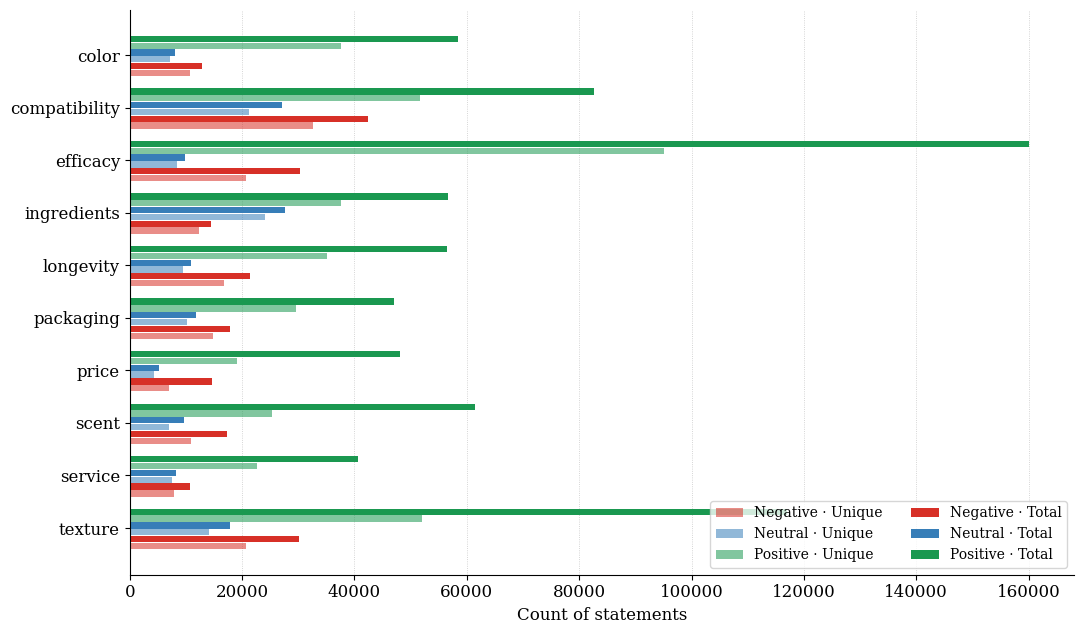

In [34]:
os.makedirs("plots", exist_ok=True)
plot_topic_sentiment_bars(
    final_correct_triplets_df_stats, 
    os.path.join("plots", dataset_name + "_topic_sentiment_statement_distribution.pdf")
)

In [35]:
new_data_df.to_csv(os.path.join(dataset_dir, "processed_dataset.csv"))

In [36]:
all_statements = []
all_topics = []
all_sentiments = []
all_freq = []

for i, ((statement, topic, sent), id_freq) in enumerate(all_triplets.items()):
    freq = id_freq["freq"]
    all_statements.append(statement)
    all_topics.append(topic)
    all_sentiments.append(sent)
    all_freq.append(freq)
    if i % 10_000 == 0:
        print((statement, topic, sent), freq)

statement_topic_sentiment_freq_df = pd.DataFrame({
    "statement": all_statements,
    "topic": all_topics,
    "sentiment": all_sentiments,
    "frequency": all_freq
})

print(len(statement_topic_sentiment_freq_df))

('has oily texture', 'texture', 'negative') 169
('performs similarly to regular apricot scrub', 'efficacy', 'positive') 1
('does not match expected tropical warm scent', 'scent', 'negative') 1
('smoothes out makeup application', 'texture', 'positive') 1
('causes no pressure headaches', 'compatibility', 'positive') 1
('lashes hold curl all day', 'longevity', 'positive') 1
('colors the waterline', 'color', 'positive') 1
('has a small opening in the bottle', 'packaging', 'negative') 1
('buttons are not well placed', 'packaging', 'negative') 1
('clears pimples within 24 hours', 'efficacy', 'positive') 1
('dried lemongrass has unpleasant texture in mouth', 'scent', 'negative') 1
('provides a moisturizing base for foundation', 'efficacy', 'positive') 1
('make setting hair easier', 'texture', 'positive') 1
('rosewood has a coolish tone with enough warmth', 'color', 'positive') 1
('recommended by cousin', 'service', 'neutral') 1
('has a natural astringent and toning effect', 'ingredients', 'po

('has the exact brand and color', 'color', 'positive') 1
('requires a bit of work and pulling to detangle', 'texture', 'neutral') 1
('covers a lot of skin with a small amount', 'efficacy', 'positive') 2
('starts stinging after a minute', 'scent', 'negative') 1
('has perfect heat', 'efficacy', 'positive') 1
('color differs from picture', 'color', 'negative') 2
('performs well for cleansing the face', 'efficacy', 'positive') 1
('requires several coats', 'compatibility', 'negative') 1
('does not work well for wavy frizzy hair', 'compatibility', 'negative') 1
('is kept handy for shopping trips', 'packaging', 'positive') 1
('nail art rhinestones tend to pop off easily', 'longevity', 'negative') 1
('can be improved with saline addition', 'texture', 'neutral') 1
('has knotted lashes on white filament', 'ingredients', 'negative') 1
('will not use a different product', 'service', 'positive') 1
('has instant foaming action', 'texture', 'positive') 1
('result is bad', 'efficacy', 'negative') 1
('

('initially felt too big for eyes', 'compatibility', 'negative') 1
('has new and fresh designs', 'color', 'positive') 1
('uses sulfate free wash', 'ingredients', 'positive') 1
('allows for quick showering', 'longevity', 'positive') 1
('brushes work well on the face', 'efficacy', 'positive') 1
('is part of daily regimen', 'longevity', 'positive') 1
('costs less than twice the price of other colors', 'price', 'positive') 1
('could be more moisturizing', 'efficacy', 'neutral') 1
('cleanser has a bit of a scrub to it', 'texture', 'neutral') 1
('does not fit all plates', 'compatibility', 'negative') 1
('was sent incorrect color', 'color', 'negative') 1
('gives glossy finish', 'texture', 'positive') 1
('the scent lingers on hair', 'scent', 'positive') 1
('works well on long thin hair', 'compatibility', 'positive') 1
('does not feel blades against skin', 'texture', 'positive') 1
('reduces pores', 'longevity', 'positive') 1
('can cause discomfort on ears', 'compatibility', 'negative') 1
('adju

673612


In [37]:
print(statement_topic_sentiment_freq_df.sample(n=10))

                                                statement        topic  \
291920   compared lotion to salon package, color is exact        color   
172838                top coat makes the nail last longer    longevity   
496110  head and shoulders is a common shampoo with zi...  ingredients   
135160                     planned to reorder the product      service   
642459                    does not leave hair super shiny    longevity   
231476                 unclumps clumps from other mascara     efficacy   
234319                         is great for treating acne     efficacy   
223822                             has a fine performance     efficacy   
220022                  has a convenient, one step design      texture   
24596                 increases hair thickness appearance     efficacy   

       sentiment  frequency  
291920  positive          1  
172838  positive          1  
496110   neutral          1  
135160  positive          1  
642459   neutral          1  
23147

In [38]:
statement_topic_sentiment_freq_df.to_csv(os.path.join(dataset_dir, "statement_topic_sentiment_freq.csv"))

In [39]:
def analyze_statements_dataset(df):
    print("=" * 80)
    print("STATEMENT DATASET STATISTICAL ANALYSIS")
    print("=" * 80)
    
    # General statistics
    print("\nGENERAL STATISTICS")
    print("-" * 40)
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()
    n_interactions = len(df)
    
    print(f"Unique users: {n_users:,}")
    print(f"Unique items: {n_items:,}")
    print(f"Total interactions: {n_interactions:,}")
    
    # Expand statements for analysis
    expanded_data = []
    for idx, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        statements = row['statements']
        
        if isinstance(statements, list):
            for stmt_dict in statements:
                if isinstance(stmt_dict, dict):
                    expanded_data.append({
                        'user_id': user_id,
                        'item_id': item_id,
                        'interaction_id': idx,
                        'statement': stmt_dict.get('statement', ''),
                        'topic': stmt_dict.get('topic', ''),
                        'sentiment': stmt_dict.get('sentiment', '')
                    })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    if expanded_df.empty:
        print("No valid statements found in the dataset")
        return
    
    print(f"Total statements: {len(expanded_df):,}")
    print(f"Unique statements: {expanded_df['statement'].nunique():,}")
    
    # Get unique sentiments and topics
    sentiments = sorted(expanded_df['sentiment'].unique())
    topics = sorted(expanded_df['topic'].unique())
    
    print(f"Sentiments: {sentiments}")
    print(f"Topics ({len(topics)}): {topics}")
    
    # Function to calculate statistics
    def calculate_stats(data, group_by, count_by='statement', unique=True):
        if unique:
            # Count unique statements
            stats = data.groupby(group_by)[count_by].nunique()
        else:
            # Count with frequency (all statements)
            stats = data.groupby(group_by)[count_by].count()
        
        return {
            'average': stats.mean(),
            'maximum': stats.max(),
            'minimum': stats.min(),
            'median': stats.median(),
            'std': stats.std()
        }
    
    # 1. USER STATISTICS
    print("\n" + "=" * 80)
    print("USER STATISTICS")
    print("=" * 80)
    
    user_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'user_id', unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per user/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['user_id', 'topic'], unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/user
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    user_stats_df = pd.DataFrame(user_stats_results)
    print(user_stats_df.to_string(index=False))
    
    # 2. ITEM STATISTICS
    print("\n" + "=" * 80)
    print("ITEM STATISTICS")
    print("=" * 80)
    
    item_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'item_id', unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per item/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['item_id', 'topic'], unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/item
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    item_stats_df = pd.DataFrame(item_stats_results)
    print(item_stats_df.to_string(index=False))
    
    # 3. INTERACTION STATISTICS
    print("\n" + "=" * 80)
    print("INTERACTION STATISTICS")
    print("=" * 80)
    
    interaction_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'interaction_id', unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per interaction/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['interaction_id', 'topic'], unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/interaction
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    interaction_stats_df = pd.DataFrame(interaction_stats_results)
    print(interaction_stats_df.to_string(index=False))
    
    # 4. SENTIMENT AND TOPIC DISTRIBUTION
    print("\n" + "=" * 80)
    print("SENTIMENT AND TOPIC DISTRIBUTION")
    print("=" * 80)
    
    # Sentiment distribution
    sentiment_counts = expanded_df['sentiment'].value_counts()
    sentiment_unique_counts = expanded_df.groupby('sentiment')['statement'].nunique()
    
    sentiment_dist = pd.DataFrame({
        'Sentiment': sentiment_counts.index,
        'Total_Count': sentiment_counts.values,
        'Unique_Count': [sentiment_unique_counts.get(s, 0) for s in sentiment_counts.index],
        'Total_Percentage': (sentiment_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (sentiment_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("Sentiment distribution:")
    print(sentiment_dist.round(2).to_string(index=False))
    
    # Topic distribution
    topic_counts = expanded_df['topic'].value_counts()
    topic_unique_counts = expanded_df.groupby('topic')['statement'].nunique()
    
    topic_dist = pd.DataFrame({
        'Topic': topic_counts.index,
        'Total_Count': topic_counts.values,
        'Unique_Count': [topic_unique_counts.get(t, 0) for t in topic_counts.index],
        'Total_Percentage': (topic_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (topic_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("\nTopic distribution:")
    print(topic_dist.round(2).to_string(index=False))
    
    # 5. SENTIMENT x TOPIC CROSS-MATRIX
    print("\n" + "=" * 80)
    print("SENTIMENT x TOPIC CROSS-MATRIX")
    print("=" * 80)
    
    # With frequency
    cross_matrix_freq = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], margins=True)
    print("Matrix with frequency:")
    print(cross_matrix_freq)
    
    # Unique statements
    cross_matrix_unique = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], 
                                    values=expanded_df['statement'], aggfunc='nunique', margins=True)
    print("\nMatrix with unique statements:")
    print(cross_matrix_unique.fillna(0).astype(int))
    
    # 6. COMPREHENSIVE STATISTICS SUMMARY
    print("\n" + "=" * 80)
    print("COMPREHENSIVE STATISTICS SUMMARY")
    print("=" * 80)
    
    # Create a comprehensive summary DataFrame
    summary_stats = []
    
    # Helper function to add stats
    def add_stats(group_type, group_cols, sentiment_filter=None, topic_filter=None):
        data = expanded_df.copy()
        
        if sentiment_filter:
            data = data[data['sentiment'] == sentiment_filter]
        if topic_filter:
            data = data[data['topic'] == topic_filter]
        
        if data.empty:
            return
        
        for unique in [True, False]:
            count_type = "Unique" if unique else "Frequency"
            
            if unique:
                grouped = data.groupby(group_cols)['statement'].nunique()
            else:
                grouped = data.groupby(group_cols)['statement'].count()
            
            summary_stats.append({
                'Grouping': group_type,
                'Sentiment': sentiment_filter or 'All',
                'Topic': topic_filter or 'All',
                'Count_Type': count_type,
                'Average': round(grouped.mean(), 2),
                'Maximum': int(grouped.max()),
                'Minimum': int(grouped.min()),
                'Median': round(grouped.median(), 2),
                'Std_Dev': round(grouped.std(), 2)
            })
    
    # Add all combinations
    add_stats('Per user', ['user_id'])
    add_stats('Per user/topic', ['user_id', 'topic'])
    add_stats('Per item', ['item_id'])
    add_stats('Per item/topic', ['item_id', 'topic'])
    add_stats('Per interaction', ['interaction_id'])
    add_stats('Per interaction/topic', ['interaction_id', 'topic'])
    
    # By sentiment
    for sentiment in sentiments:
        add_stats('Per user', ['user_id'], sentiment_filter=sentiment)
        add_stats('Per item', ['item_id'], sentiment_filter=sentiment)
        add_stats('Per interaction', ['interaction_id'], sentiment_filter=sentiment)

    for topic in topics:
        add_stats('Per user', ['user_id'], topic_filter=topic)
        add_stats('Per item', ['item_id'], topic_filter=topic)
        add_stats('Per interaction', ['interaction_id'], topic_filter=topic)
    
    summary_df = pd.DataFrame(summary_stats)
    print("Comprehensive statistics summary:")
    print(summary_df.to_string(index=False))
    
    # 7. TOP CONTRIBUTORS
    print("\n" + "=" * 80)
    print("TOP CONTRIBUTORS")
    print("=" * 80)
    
    # Top users
    top_users_freq = expanded_df.groupby('user_id')['statement'].count().nlargest(5)
    top_users_unique = expanded_df.groupby('user_id')['statement'].nunique().nlargest(5)
    
    print("Top 5 users (by statement frequency):")
    for user_id, count in top_users_freq.items():
        print(f"  {user_id}: {count} statements")
    
    print("\nTop 5 users (by unique statements):")
    for user_id, count in top_users_unique.items():
        print(f"  {user_id}: {count} unique statements")
    
    # Top items
    top_items_freq = expanded_df.groupby('item_id')['statement'].count().nlargest(5)
    top_items_unique = expanded_df.groupby('item_id')['statement'].nunique().nlargest(5)
    
    print("\nTop 5 items (by statement frequency):")
    for item_id, count in top_items_freq.items():
        print(f"  {item_id}: {count} statements")
    
    print("\nTop 5 items (by unique statements):")
    for item_id, count in top_items_unique.items():
        print(f"  {item_id}: {count} unique statements")
    
    # 8. DIVERSITY STATISTICS
    print("\n" + "=" * 80)
    print("DIVERSITY STATISTICS")
    print("=" * 80)
    
    diversity_stats = []
    
    # Diversity per user (number of different topics)
    user_topic_diversity = expanded_df.groupby('user_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per user',
        'Average': round(user_topic_diversity.mean(), 2),
        'Maximum': int(user_topic_diversity.max()),
        'Minimum': int(user_topic_diversity.min()),
        'Median': round(user_topic_diversity.median(), 2)
    })
    
    # Diversity per user (number of different sentiments)
    user_sentiment_diversity = expanded_df.groupby('user_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per user',
        'Average': round(user_sentiment_diversity.mean(), 2),
        'Maximum': int(user_sentiment_diversity.max()),
        'Minimum': int(user_sentiment_diversity.min()),
        'Median': round(user_sentiment_diversity.median(), 2)
    })
    
    # Diversity per item
    item_topic_diversity = expanded_df.groupby('item_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per item',
        'Average': round(item_topic_diversity.mean(), 2),
        'Maximum': int(item_topic_diversity.max()),
        'Minimum': int(item_topic_diversity.min()),
        'Median': round(item_topic_diversity.median(), 2)
    })
    
    item_sentiment_diversity = expanded_df.groupby('item_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per item',
        'Average': round(item_sentiment_diversity.mean(), 2),
        'Maximum': int(item_sentiment_diversity.max()),
        'Minimum': int(item_sentiment_diversity.min()),
        'Median': round(item_sentiment_diversity.median(), 2)
    })
    
    diversity_df = pd.DataFrame(diversity_stats)
    print("Diversity statistics:")
    print(diversity_df.to_string(index=False))
    
    # 9. STATEMENT FREQUENCY ANALYSIS
    print("\n" + "=" * 80)
    print("STATEMENT FREQUENCY ANALYSIS")
    print("=" * 80)
    
    # Most frequent statements
    statement_freq = expanded_df['statement'].value_counts()
    print("Top 10 most frequent statements:")
    for i, (stmt, count) in enumerate(statement_freq.head(10).items(), 1):
        print(f"  {i:2d}. '{stmt[:50]}{'...' if len(stmt) > 50 else ''}' (count: {count})")
    
    # Statement length statistics
    expanded_df['statement_length'] = expanded_df['statement'].str.len()
    length_stats = expanded_df['statement_length'].describe()
    
    print(f"\nStatement length statistics:")
    print(f"  Average length: {length_stats['mean']:.1f} characters")
    print(f"  Maximum length: {length_stats['max']:.0f} characters")
    print(f"  Minimum length: {length_stats['min']:.0f} characters")
    print(f"  Median length: {length_stats['50%']:.1f} characters")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETED")

In [40]:
analyze_statements_dataset(new_data_df)

STATEMENT DATASET STATISTICAL ANALYSIS

GENERAL STATISTICS
----------------------------------------
Unique users: 22,362
Unique items: 12,101
Total interactions: 197,621


Total statements: 1,076,769


Unique statements: 622,276
Sentiments: ['negative', 'neutral', 'positive']
Topics (10): ['color', 'compatibility', 'efficacy', 'ingredients', 'longevity', 'packaging', 'price', 'scent', 'service', 'texture']

USER STATISTICS


                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per user (Unique)       All           All   46.99    1371       2  33.00   55.89
                          Statements per user (With frequency)       All           All   48.15    1510       2  34.00   59.22
                                  Statements per user (Unique)  negative           All   10.22     275       1   7.00   12.51
                          Statements per user (With frequency)  negative           All   10.30     331       1   7.00   12.78
                                  Statements per user (Unique)   neutral           All    6.88     338       1   4.00   11.03
                          Statements per user (With frequency)   neutral           All    6.94     351       1   4.00   11.31
                                  Statements per user (Unique)  positive           All   31.60     981       1  22.00 

                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per item (Unique)       All           All   84.79    2107      10  45.00  122.24
                          Statements per item (With frequency)       All           All   88.98    2359      10  45.00  136.07
                                  Statements per item (Unique)  negative           All   17.79     431       1  10.00   26.78
                          Statements per item (With frequency)  negative           All   18.07     460       1  10.00   27.84
                                  Statements per item (Unique)   neutral           All   11.76     436       1   6.00   19.83
                          Statements per item (With frequency)   neutral           All   11.89     456       1   6.00   20.35
                                  Statements per item (Unique)  positive           All   56.66    1278       1  30.00 

                                                               Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per interaction (Unique)       All           All    5.45      21       1   5.00    2.65
                          Statements per interaction (With frequency)       All           All    5.45      21       1   5.00    2.65
                                  Statements per interaction (Unique)  negative           All    2.36      16       1   2.00    1.54
                          Statements per interaction (With frequency)  negative           All    2.36      16       1   2.00    1.54
                                  Statements per interaction (Unique)   neutral           All    1.84      19       1   1.00    1.35
                          Statements per interaction (With frequency)   neutral           All    1.84      19       1   1.00    1.35
                                  Statements per interaction (Unique)

Sentiment distribution:
Sentiment  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
 positive       728572        379226             67.66              23.75
 negative       211843        147770             19.67              17.62
  neutral       136354        109669             12.66              60.94



Topic distribution:
        Topic  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
     efficacy       200202        123048             18.59               8.73
      texture       164764         84338             15.30              16.69
compatibility       152204        103860             14.14              19.77
  ingredients        98954         72042              9.19              11.58
    longevity        88726         60237              8.24               9.68
        scent        88491         41493              8.22               8.59
        color        79306         54340              7.37               4.82
    packaging        76663         53439              7.12               6.67
        price        68021         30021              6.32               6.06
      service        59438         37726              5.52              13.55

SENTIMENT x TOPIC CROSS-MATRIX


Matrix with frequency:
topic      color  compatibility  efficacy  ingredients  longevity  packaging  \
sentiment                                                                      
negative   12798          42428     30248        14547      21331      17827   
neutral     8096          27153      9879        27696      10961      11722   
positive   58412          82623    160075        56711      56434      47114   
All        79306         152204    200202        98954      88726      76663   

topic      price  scent  service  texture      All  
sentiment                                           
negative   14608  17314    10666    30076   211843  
neutral     5224   9677     8166    17780   136354  
positive   48189  61500    40606   116908   728572  
All        68021  88491    59438   164764  1076769  



Matrix with unique statements:
topic      color  compatibility  efficacy  ingredients  longevity  packaging  \
sentiment                                                                      
negative   10699          32597     20747        12418      16709      14883   
neutral     7117          21215      8356        24031       9430      10182   
positive   37680          51632     95060        37615      35054      29552   
All        54340         103860    123048        72042      60237      53439   

topic      price  scent  service  texture     All  
sentiment                                          
negative    7073  10837     7922    20612  147770  
neutral     4364   7048     7518    14165  109669  
positive   19173  25246    22704    51973  379226  
All        30021  41493    37726    84338  622276  

COMPREHENSIVE STATISTICS SUMMARY


Comprehensive statistics summary:
             Grouping Sentiment         Topic Count_Type  Average  Maximum  Minimum  Median  Std_Dev
             Per user       All           All     Unique    46.99     1371        2    33.0    55.89
             Per user       All           All  Frequency    48.15     1510        2    34.0    59.22
       Per user/topic       All           All     Unique     5.60      294        1     4.0     8.00
       Per user/topic       All           All  Frequency     5.72      308        1     4.0     8.39
             Per item       All           All     Unique    84.79     2107       10    45.0   122.24
             Per item       All           All  Frequency    88.98     2359       10    45.0   136.07
       Per item/topic       All           All     Unique    10.00      676        1     5.0    18.25
       Per item/topic       All           All  Frequency    10.41      747        1     5.0    19.99
      Per interaction       All           All     Unique 

Top 5 users (by statement frequency):
  A1UQBFCERIP7VJ: 1510 statements
  ALNFHVS3SC4FV: 1444 statements
  A2V5R832QCSOMX: 1442 statements
  AKMEY1BSHSDG7: 1264 statements
  AEL6CQNQXONBX: 1153 statements

Top 5 users (by unique statements):
  A2V5R832QCSOMX: 1371 unique statements
  A1UQBFCERIP7VJ: 1358 unique statements
  ALNFHVS3SC4FV: 1305 unique statements
  AKMEY1BSHSDG7: 1193 unique statements
  AEL6CQNQXONBX: 1047 unique statements



Top 5 items (by statement frequency):
  B000ZMBSPE: 2359 statements
  B0043OYFKU: 2259 statements
  B003V265QW: 1912 statements
  B00639DLV2: 1797 statements
  B004OHQR1Q: 1611 statements

Top 5 items (by unique statements):
  B000ZMBSPE: 2107 unique statements
  B0043OYFKU: 1981 unique statements
  B003V265QW: 1664 unique statements
  B00639DLV2: 1416 unique statements
  B004OHQR1Q: 1343 unique statements

DIVERSITY STATISTICS


Diversity statistics:
             Metric  Average  Maximum  Minimum  Median
    Topics per user     8.42       10        1     9.0
Sentiments per user     2.80        3        1     3.0
    Topics per item     8.55       10        2     9.0
Sentiments per item     2.92        3        1     3.0

STATEMENT FREQUENCY ANALYSIS
Top 10 most frequent statements:
   1. 'has a pleasant scent' (count: 9307)
   2. 'works well' (count: 2929)
   3. 'is easy to use' (count: 2439)
   4. 'applies smoothly' (count: 1945)
   5. 'has a good price' (count: 1552)
   6. 'has a great price' (count: 1544)
   7. 'is affordable' (count: 1506)
   8. 'is highly recommended' (count: 1378)
   9. 'a little goes a long way' (count: 1337)
  10. 'works effectively' (count: 1318)



Statement length statistics:
  Average length: 27.9 characters
  Maximum length: 606 characters
  Minimum length: 4 characters
  Median length: 26.0 characters

ANALYSIS COMPLETED
